<center><h1>VC03: Clustering Jerárquico Aglomerativo</h1></center>

En esta práctica estudiaremos el funcionamiento y la utilización del clústering jerárquico aglomerativo.

Para empezar, cargamos las librerías que vamos a necesitar:

In [0]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.cluster.hierarchy import dendrogram


Para comenzar, cargamos el conjunto de datos con el que trabajaremos:


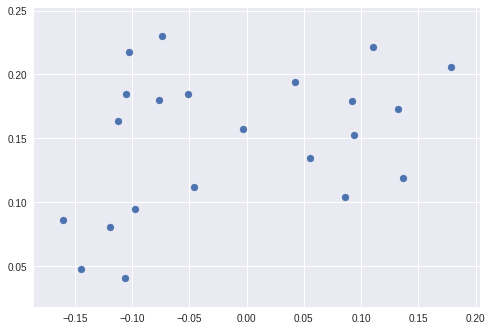

In [9]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_reducido.csv'
Dx = np.array(pd.read_csv(data_file_url,header=0))

Dx = Dx[ np.random.choice(np.arange(Dx.shape[0]), Dx.shape[0], replace=False) ,:]
plt.scatter(Dx[:,0], Dx[:,1])
plt.show()


Con este dataset trabajaremos y estudiaremos en esta práctica las diferentes variantes del clústering aglomerativo. Para empezar, será necesario calcular la matriz de distancias, por lo que recuperamos de prácticas anteriores la función matriz_distancias.  


In [0]:
def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD


Necesitamos una función que, dada una matriz de distancias, construya un clustering aglomerativo. Es decir, partiendo de n clústeres (uno por ejemplo de entrenamiento), se van uniendo iterativamente dos clústeres (escogidos según minimizan la distancia interclúster definida de acuerdo a cierto criterio) hasta que todos los elementos se agrupan en un único clúster final.

Sabemos que el número de uniones es igual a n-1 (el número de ejemplos menos uno). En la siguiente función, vamos guardando en cada columna de la matriz mParticiones la partición en clústeres de los ejemplos: cada partición mParticiones[:,p], de longitud n, guarda el clúster al que pertenece el i-ésimo ejemplo en la posición mParticiones[i,p]. Para rellenar esa matriz, en cada paso (unión), se calcula la matriz de distancia entre todos los pares de clústeres usando el criterio elegido. Después, simplemente se trata de asignar todos los elementos de los clústeres elegidos a un mismo grupo. Este procedimiento iterativo se repite hasta que sólo queda un clúster en el paso final:


In [0]:
def clustering_aglomerativo(mD, criterio):
    mParticiones = np.zeros(mD.shape[0]**2, dtype = np.int8)
    mParticiones.shape = (mD.shape[0], mD.shape[0])
    mParticiones[:,21] = np.arange(22)

    # Recorremos de manera decreciente 
    # ya que sabemos que el número de uniones es exactamente de n-1

    a = np.array(range(mParticiones.shape[1]-1))
    for n in a[::-1]:
        mParticiones[:,n] = mParticiones[:,n+1]

        clust_actuales = np.unique(mParticiones[:,n])
        mDC = criterio(mD, clust_actuales, mParticiones[:,n])

        ind = np.unravel_index(np.argmin(mDC, axis=None), mDC.shape)
        mParticiones[mParticiones[:,n]==clust_actuales[ind[1]],n] = clust_actuales[ind[0]]

    return mParticiones


En la parte teórica estudiamos tres criterios diferentes (medidas de disimilitud interclúster). El primero que vamos a ver es el de la disimilitud media: dado cierto par de clústeres, se calcula la media de la disimilitud-distancia entre todos los pares de ejemplos (uno ejemplo de cada clúster).


In [0]:
def disimilitud_media(mD, clust_actuales, particion):
    mDC = np.zeros(clust_actuales.size**2)
    mDC.shape = (clust_actuales.size,clust_actuales.size)
    for n1 in np.arange(clust_actuales.size):
        exC1 = np.where(particion==clust_actuales[n1])[0]
        for n2 in np.arange(clust_actuales.size):
            exC2 = np.where(particion==clust_actuales[n2])[0]
            mDC[n1,n2] = np.mean(mD[np.ix_(exC1,exC2)])
    # Rellenamos la matriz diagonal para evitar que se proponga
    # la unión de un clúster consigo mismo
    np.fill_diagonal(mDC, np.max(mDC)*2)
    return mDC


Con pocos cambios, se puede definir la disimilitud interclúster mínima: dado cierto par de clústeres, la distancia entre ambos es igual a la distancia mínima de cualquier par de ejemplos (uno ejemplo de cada clúster).


In [0]:
def disimilitud_maxima(mD, clust_actuales, particion):
    mDC = np.zeros(clust_actuales.size**2)
    mDC.shape = (clust_actuales.size,clust_actuales.size)
    for n1 in np.arange(clust_actuales.size):
        exC1 = np.where(particion==clust_actuales[n1])[0]
        for n2 in np.arange(clust_actuales.size):
            exC2 = np.where(particion==clust_actuales[n2])[0]
            mDC[n1,n2] = np.max(mD[np.ix_(exC1,exC2)])
    # Rellenamos la matriz diagonal para evitar que se proponga
    # la unión de un clúster consigo mismo
    np.fill_diagonal(mDC, np.max(mDC)*2)
    return mDC


De manera equivalente, se define la disimilitud interclúster máxima: dado cierto par de clústeres, la distancia entre ambos es igual a la distancia máxima de cualquier par de ejemplos (uno ejemplo de cada clúster).


In [0]:
def disimilitud_minima(mD, clust_actuales, particion):
    mDC = np.zeros(clust_actuales.size**2)
    mDC.shape = (clust_actuales.size,clust_actuales.size)
    for n1 in np.arange(clust_actuales.size):
        exC1 = np.where(particion==clust_actuales[n1])[0]
        for n2 in np.arange(clust_actuales.size):
            exC2 = np.where(particion==clust_actuales[n2])[0]
            mDC[n1,n2] = np.min(mD[np.ix_(exC1,exC2)])
    # Rellenamos la matriz diagonal para evitar que se proponga
    # la unión de un clúster consigo mismo
    np.fill_diagonal(mDC, np.max(mDC)*2)
    return mDC


Finalmente, incluimos una serie de funciones que nos van a permitir visualizar los resultados:


In [0]:
# Muestra los ejemplos coloreados según su pertenencia a los clústeres
# K indica el número de clústeres a mostrar a partir de la jerarquía
def plot_particion_K(Dx, mParticiones,K):
    cmap = get_cmap('tab20')
    vals = np.arange(Dx.shape[0]+2)/(Dx.shape[0]+2)
    rgba = cmap(vals[np.arange(Dx.shape[0])+1])

    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(Dx[:,0],Dx[:,1], c=rgba[mParticiones[:,K-1],:])

# Muestra el plot de todas las particiones posibles de la jerarquía
def plot_particiones(Dx, mParticiones):
    for k in np.arange(mParticiones.shape[1]):
        plot_particion_K(Dx, mParticiones,k+1)

# Muestra el dendrograma de la jerarquía
def plot_dendrograma_de_mparticiones(mD, mParticiones):
    nPasos = mD.shape[0]-1
    distancias = np.zeros(nPasos)
    tamanyos = np.zeros(nPasos)
    uniones = np.zeros(2*nPasos,dtype=np.int8)
    uniones.shape=(nPasos,2)

    mNParticiones = mParticiones.copy()
    for n in np.arange(mNParticiones.shape[0]):
        valor = mParticiones[n,mNParticiones.shape[1]-1]
        mNParticiones[mParticiones==valor] = n

    k = 0
    aux = np.array(range(mNParticiones.shape[1]-1))
    for n in aux[::-1]:
        # cual es el diferente?
        prim_diferencia = np.where(mParticiones[:,n]!=mParticiones[:,n+1])[0][0]
        submatriz = mNParticiones[:,:n+1]
        submatriz[submatriz==mNParticiones[prim_diferencia,n]] = mNParticiones.shape[1]+k
        mNParticiones[:,:n+1] = submatriz
        uniones[k,:] = np.unique(mNParticiones[mNParticiones[:,n]==mNParticiones.shape[1]+k,n+1])
        tamanyos[k] = np.sum(mNParticiones[:,n]==mNParticiones.shape[1]+k)

        vs = mNParticiones[:,n+1]
        distancias[k] = 1 / (2 * tamanyos[k]) * (    
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,0])[0],
                              np.where(vs == uniones[k,1])[0])])+
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,1])[0],
                              np.where(vs == uniones[k,0])[0])]))
        k += 1

    distancias = np.arange(uniones.shape[0])
    # Creamos la matriz de enlaces que necesita el método dendrogram de scipy
    mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

    plt.figure(figsize=(25, 10))
    plt.title('Dendrograma de Clustering Jerárquico')
    plt.xlabel('Índice del caso')
    plt.ylabel('Distancia')
    dendrogram(mEnlaces)
    plt.show()



Ahora ya estamos en disposición de realizar el clustering jerárquico aglomerativo. Empezaremos por calcular la matriz de distancias y, por este orden, calcularemos y mostraremos el dendrograma de los diferentes agrupamientos obtenidos de usar el criterio de disimilitud mínima, máxima y media. 


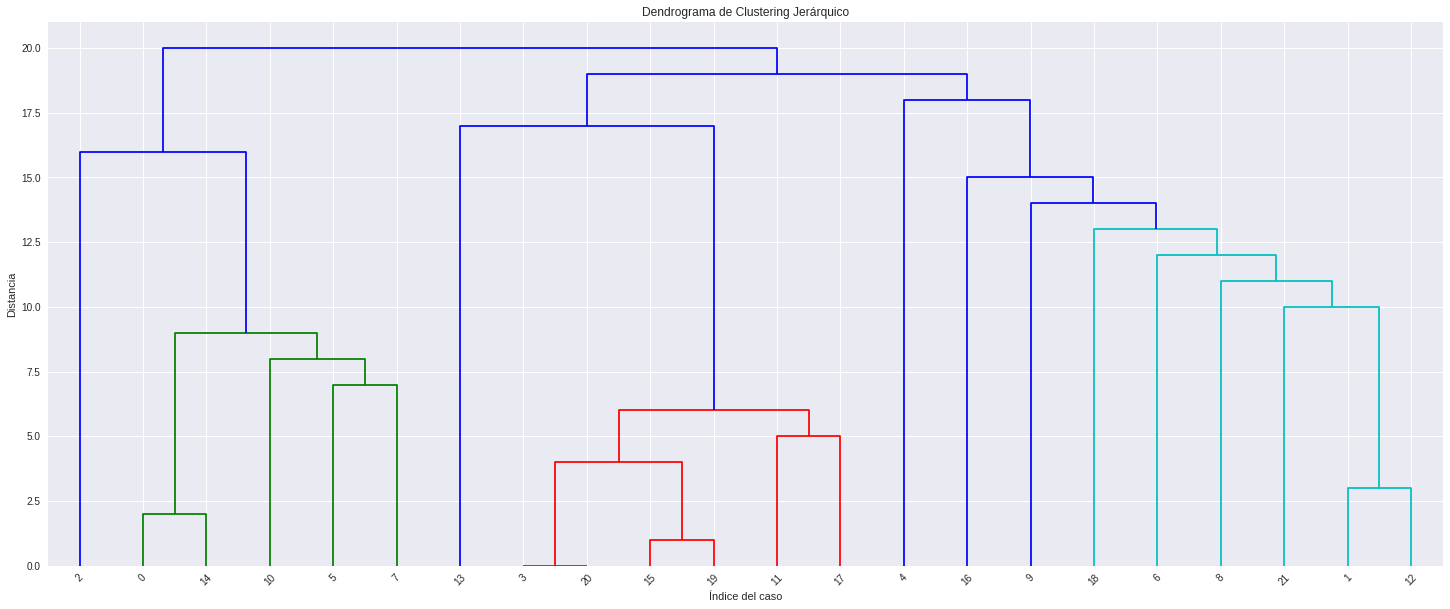

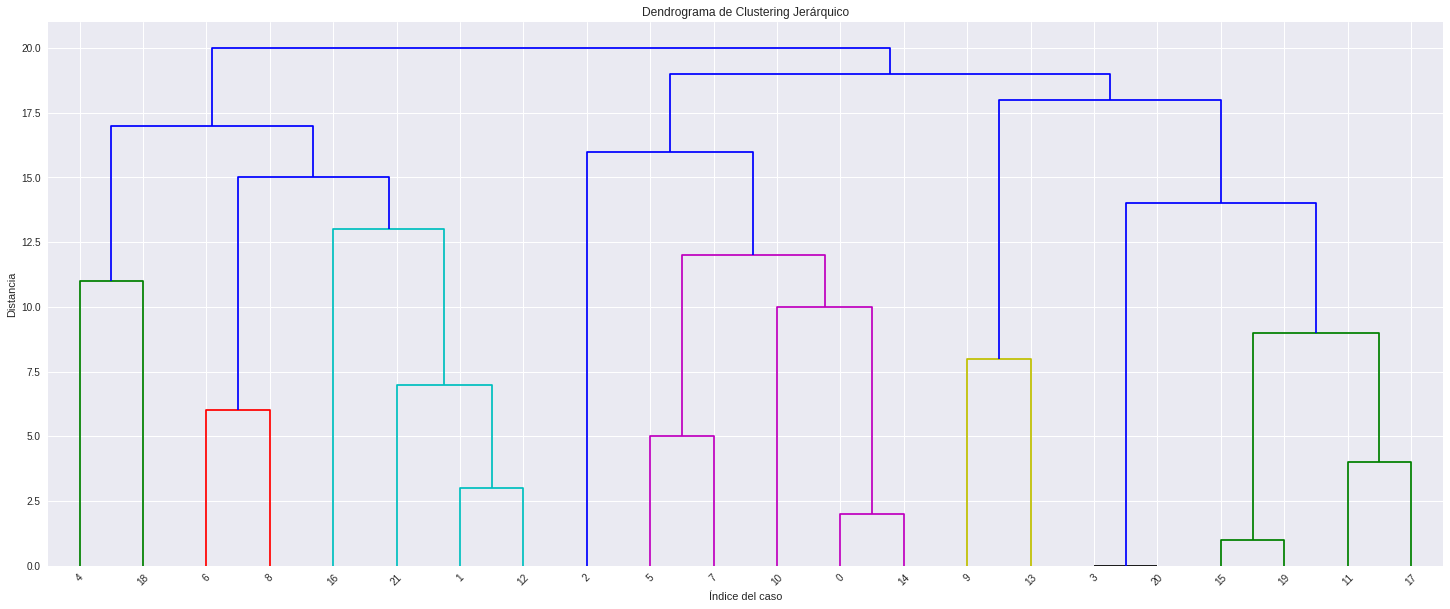

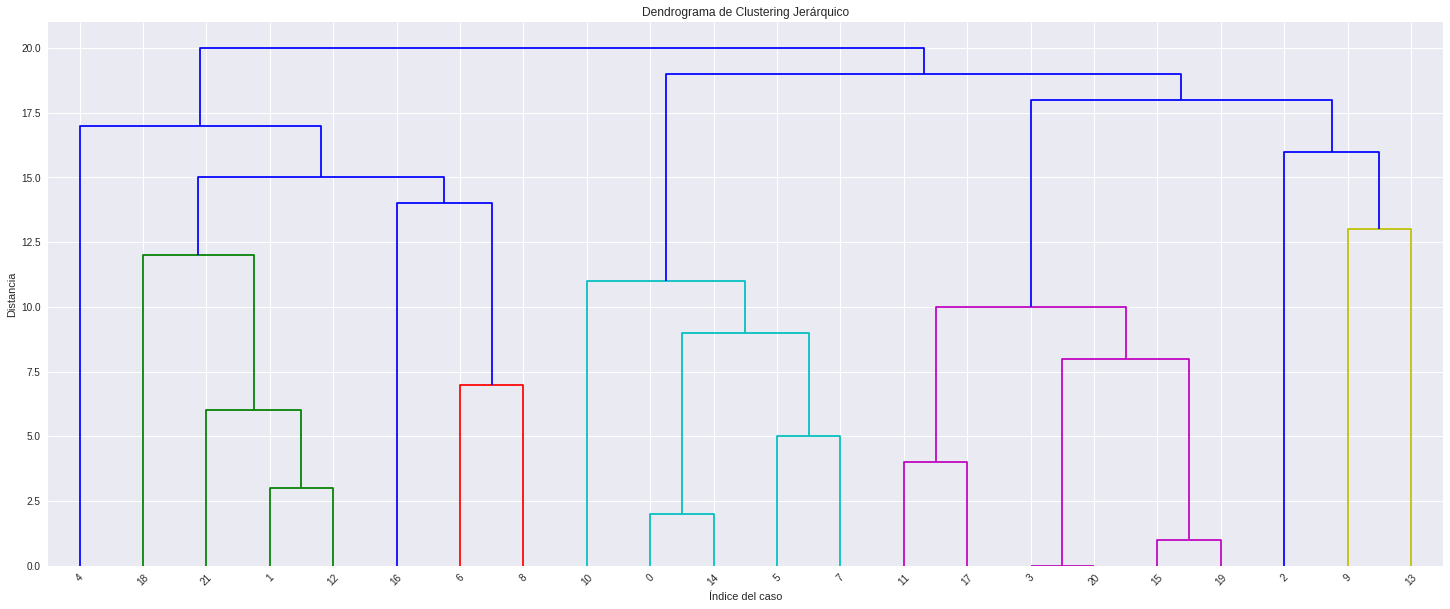

In [16]:
mD = matriz_distancias(Dx, distancia_euclidiana)

mParticiones = clustering_aglomerativo(mD, disimilitud_minima)
plot_dendrograma_de_mparticiones(mD,mParticiones)

mParticiones = clustering_aglomerativo(mD, disimilitud_maxima)
plot_dendrograma_de_mparticiones(mD,mParticiones)

mParticiones = clustering_aglomerativo(mD, disimilitud_media)
plot_dendrograma_de_mparticiones(mD,mParticiones)


La función plot_particiones permite observar cómo son las diferentes particiones (niveles del clustering jerárquico) mostrando el dataset original con la asignación a clústeres descrita mediante colores: 


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3]
 [ 0  1  1  1  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5  5  5  5  5  5  5  5  5  5]
 [ 0  1  1  1  1  1  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5  5  5  5  7  7  7  7  7  7]
 [ 0  1  1  1  1  1  6  6  6  6  6  6  6  6  8  8  8  8  8  8  8  8]
 [ 0  0  2  2  2  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9]
 [ 0  0  0  0  0  0  0  0  0  0 10 10 10 10 10 10 10 10 10 10 10 10]
 [ 0  0  2  3  3  3  3  3  3  3  3 11 11 11 11 11 11 11 11 11 11 11]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12 12 12 12]
 [ 0  0  2  2  2  9  9  9 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [ 0  0  0  0  0  0  0  0  0  0  0

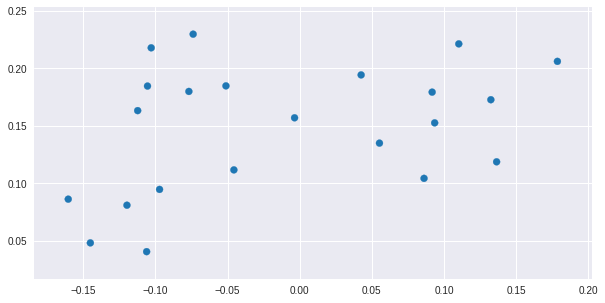

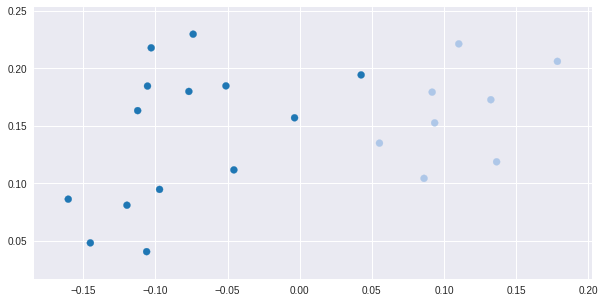

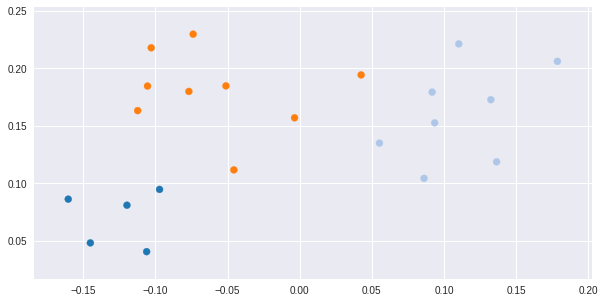

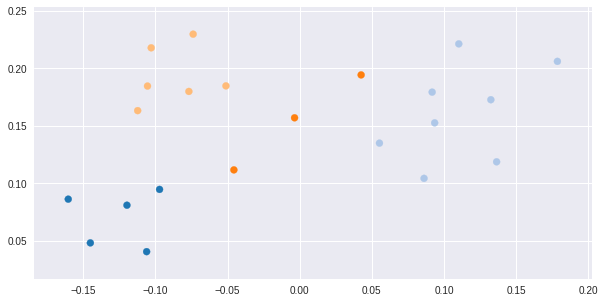

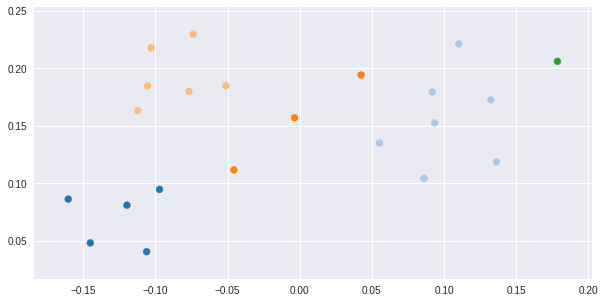

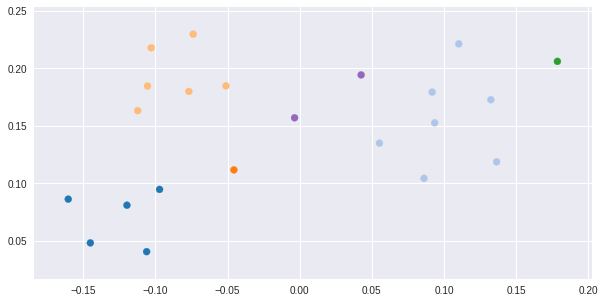

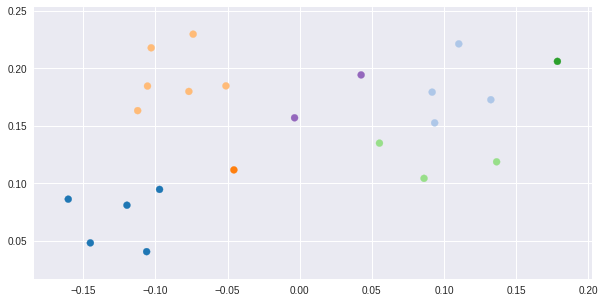

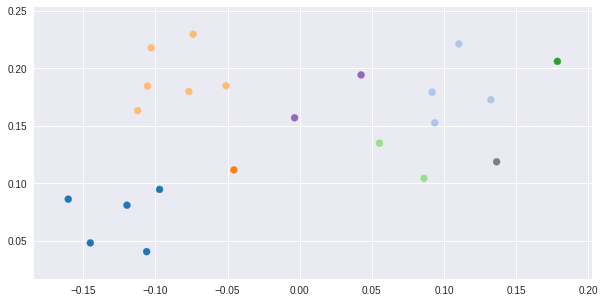

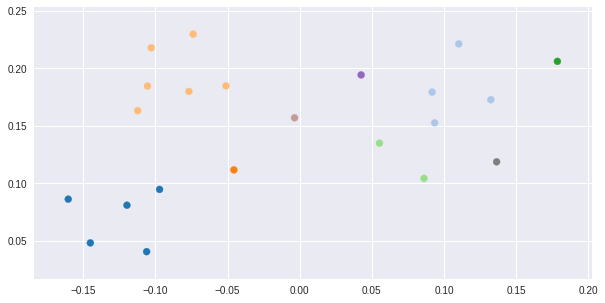

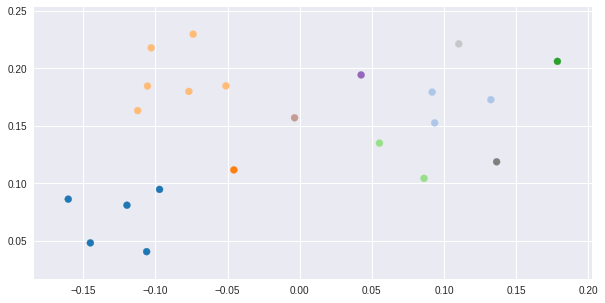

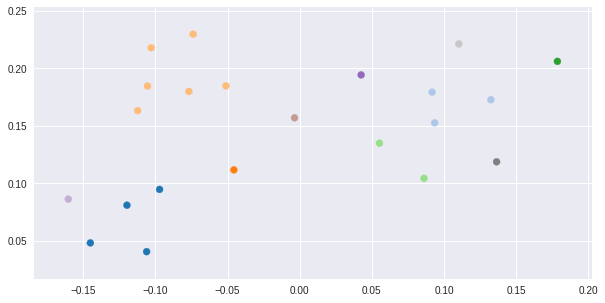

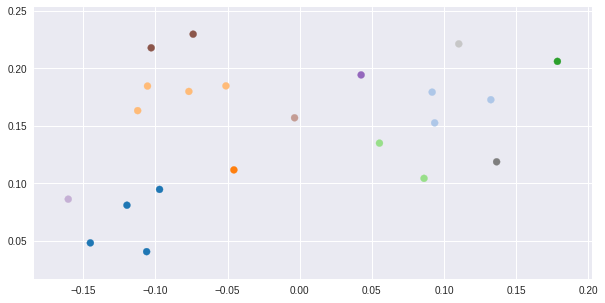

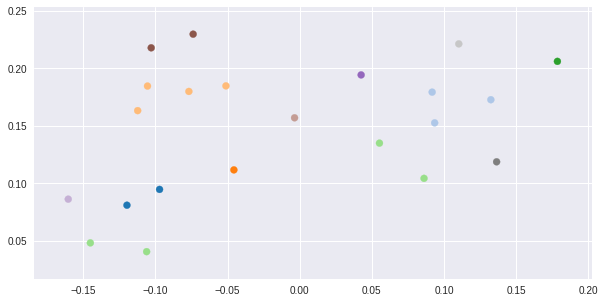

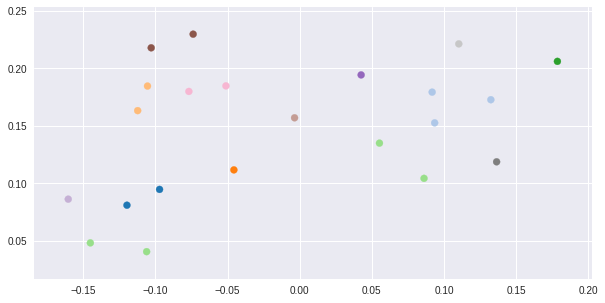

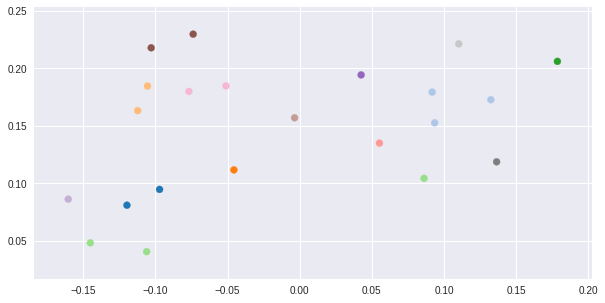

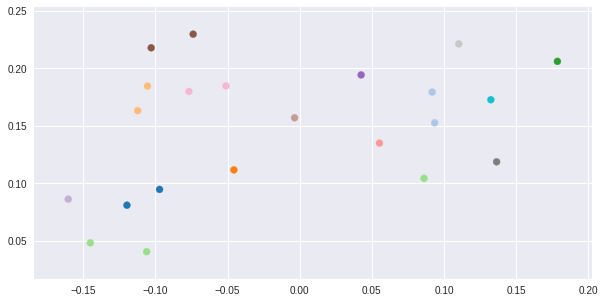

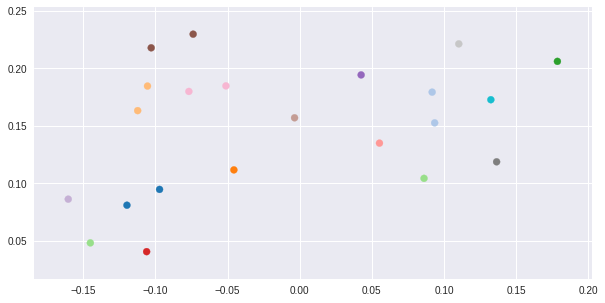

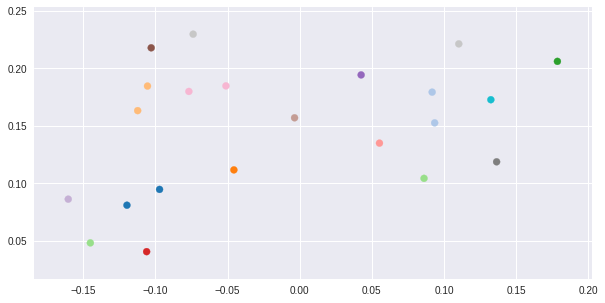

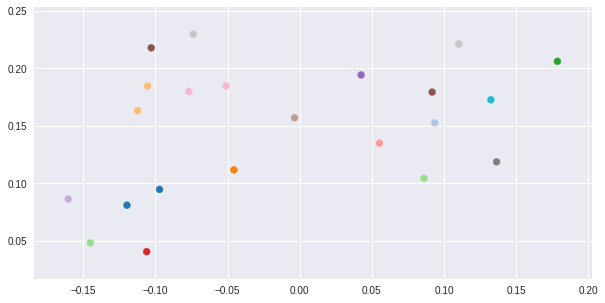

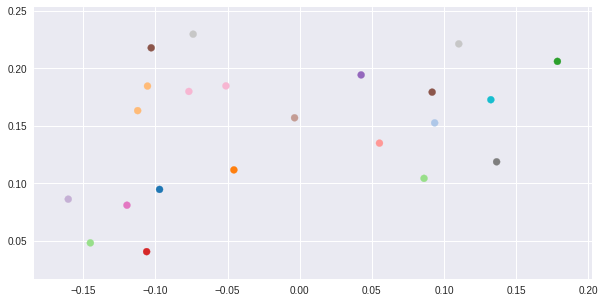

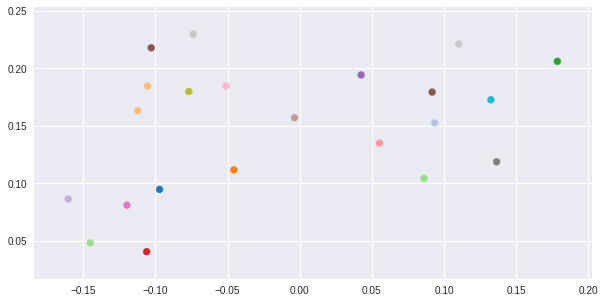

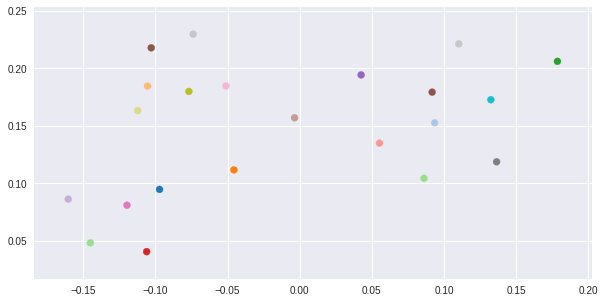

In [18]:

plot_particiones(Dx, mParticiones)



El clustering jerárquico devuelve un espectro de agrupamientos. Muchas veces, es necesario seleccionar una única partición. Dada la matriz mParticiones, esto equivalente a quedarse con una de las columnas. Si queremos seleccionar una partición donde hayan K clústeres, debemos seleccionar la columna K-1. Así, podemos calcular el valor de una métrica de evaluación cualquiera. En este caso, usamos las métricas de ancho de silueta y de Calinski Harabaz:


In [19]:
from sklearn.metrics import silhouette_score,calinski_harabaz_score

K = 4
partToEval = mParticiones[:,K-1]

print('La medida de Silueta con K =',K,'es',silhouette_score(Dx,partToEval),
      ' (** ESTE ES EL RESULTADO A INCLUIR EN EL CAMPUS**)')
print('La medida de Calinski Harabaz con K =',K,'es',calinski_harabaz_score(Dx, partToEval))

La medida de Silueta con K = 4 es 0.4408872869802952  (** ESTE ES EL RESULTADO A INCLUIR EN EL CAMPUS**)
La medida de Calinski Harabaz con K = 4 es 39.06472472659191



Podríamos incluso dibujar de manera sencilla la figura del codo recorriendo todas las columnas:


Text(0, 0.5, 'Medida de Calinski Harabaz')

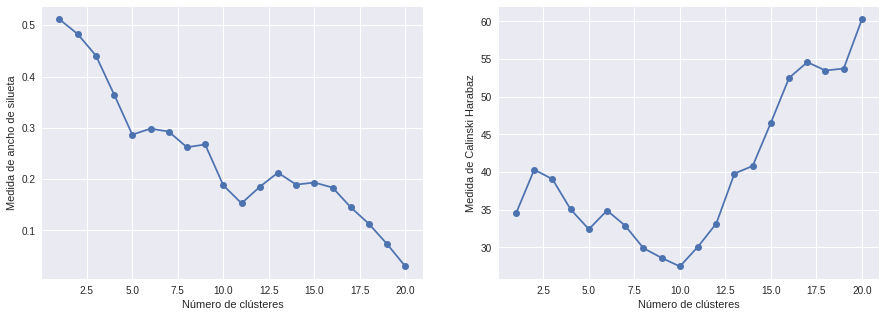

In [20]:
rsilueta = np.zeros(mParticiones.shape[1])
rch = np.zeros(mParticiones.shape[1])
for K in np.arange(1,mParticiones.shape[1]-1):
    rsilueta[K] = silhouette_score(Dx, mParticiones[:,K])
    rch[K] = calinski_harabaz_score(Dx, mParticiones[:,K])

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,mParticiones.shape[1]-1), rsilueta[np.arange(1,mParticiones.shape[1]-1)],
           linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot(np.arange(1,mParticiones.shape[1]-1), rch[np.arange(1,mParticiones.shape[1]-1)],
           linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de Calinski Harabaz")


<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering jerárquico aglomerativo. 

Están implementados (parámetro linkage) los criterios estudiados en teoría (disimilitud mínima : 'single'; máxima: 'complete'; y media: 'average') y muchos más.


In [0]:
from sklearn.cluster import AgglomerativeClustering

modelo = AgglomerativeClustering(linkage="single")
modelo = modelo.fit(Dx)

modelo = AgglomerativeClustering(linkage="complete")
modelo = modelo.fit(Dx)

modelo = AgglomerativeClustering(linkage="average")
modelo = modelo.fit(Dx)



 En cambio, para mostrar el dendrograma, tenemos que usar la library scipy:


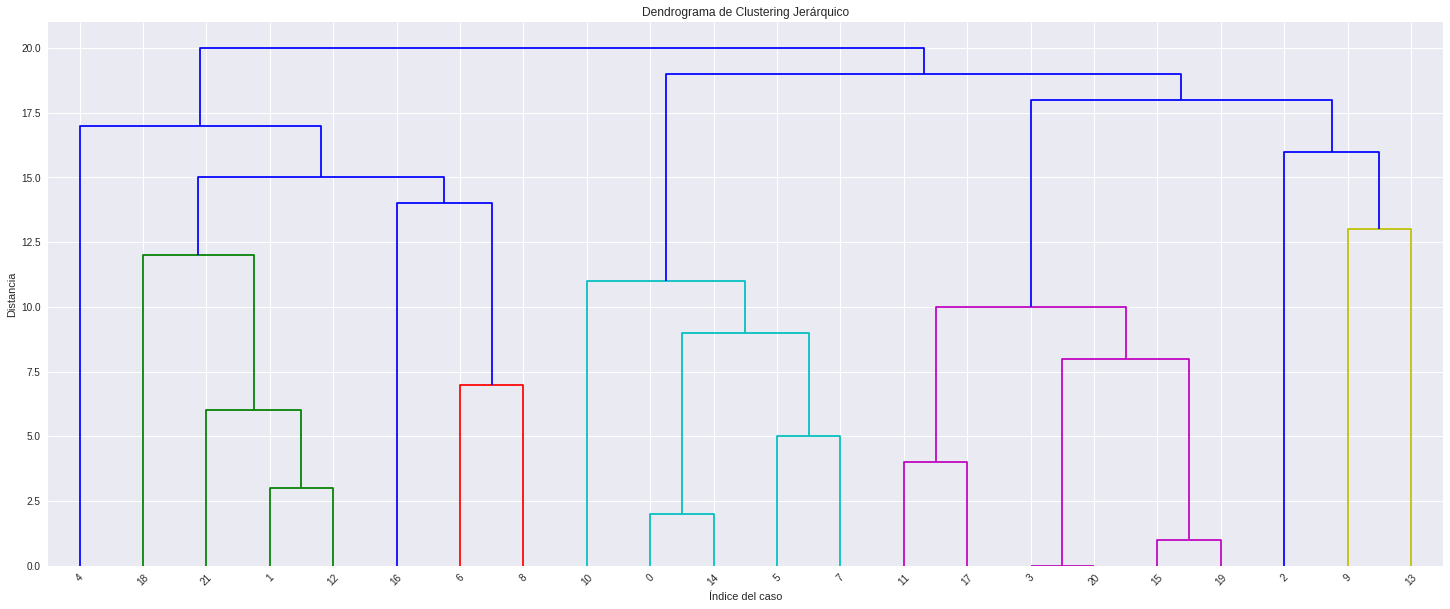

In [22]:
# Creamos la matriz de enlaces que necesita el método dendrogram de scipy
uniones = modelo.children_
# Las distancias y los tamaños, en esta ocasión, los asignamos de manera 
# inocua para no alterar el resultado (no disponemos de la información completa)
distancias = np.arange(uniones.shape[0])
tamanyos = np.arange(2, uniones.shape[0]+2)
mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

plt.figure(figsize=(25, 10))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(mEnlaces)
plt.show()


Probablemente, la librería más completa para hacer clustering jerárquico aglomerativo es scipy. La función linkage es la encargada de hacer el agrupamiento jerárquico. 


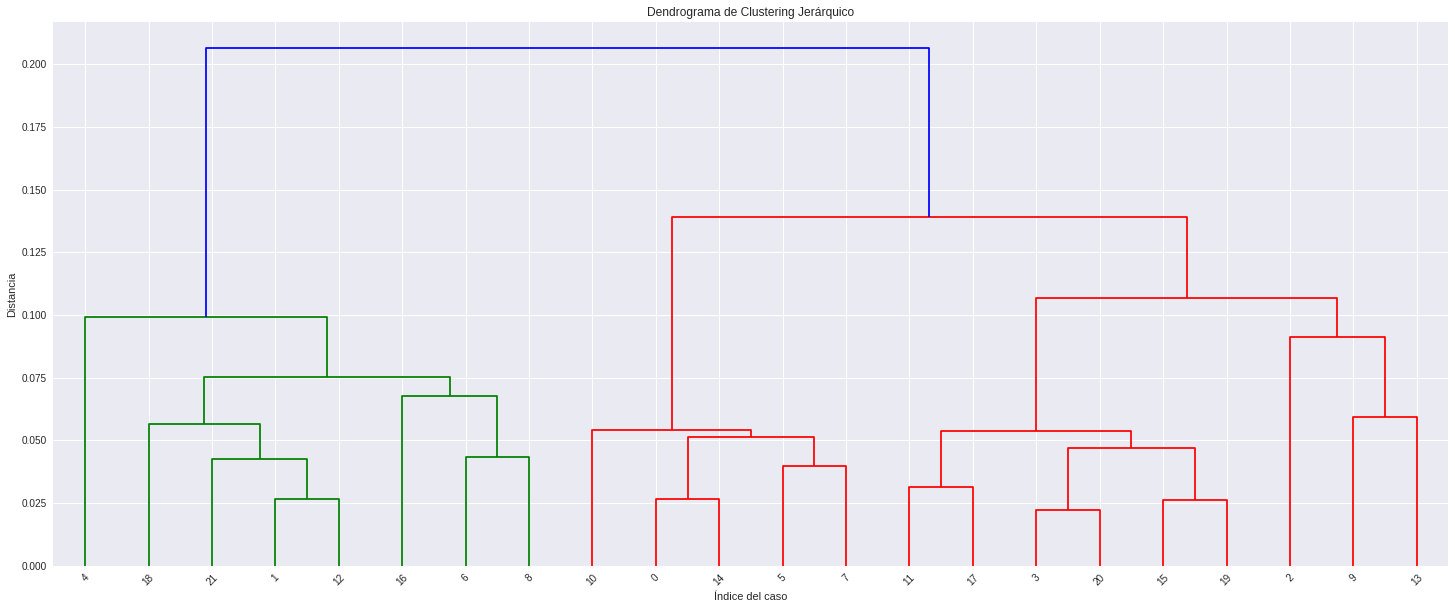

In [23]:
from scipy.cluster.hierarchy import linkage, fcluster, cut_tree

modelo = linkage(Dx, 'single')   # disimilitud mínima
modelo = linkage(Dx, 'complete') # disimilitud máxima
modelo = linkage(Dx, 'average')  # disimilitud media

plt.figure(figsize=(25, 10))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo)
plt.show()


La función cut_tree permite obtener una partición concreta dado un número de clústeres


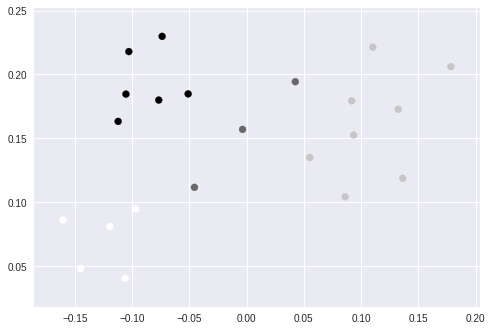

In [24]:
plt.scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters=4).flatten())
plt.show()


Con la siguiente función dibujaremos los resultados del clustering (fijado un K) usando diferentes criterios de unión. Podemos usar diferentes datasets de ejemplo (ver aquellos que tiene 2 dimensiones en:
https://github.com/jhernandezgonzalez/unsupervisedlearning/tree/master/datasets

Podemos hacer unas pruebas para ganar algunas intuiciones sobre cuál es la mejor estrategia según el tipo de datos...


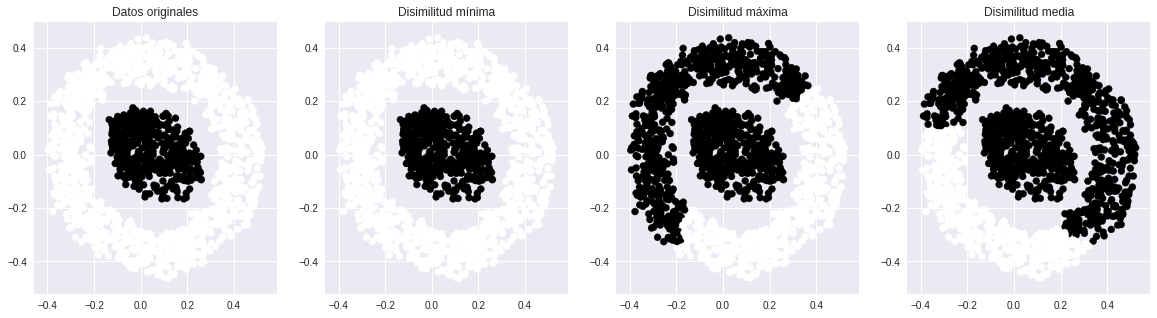

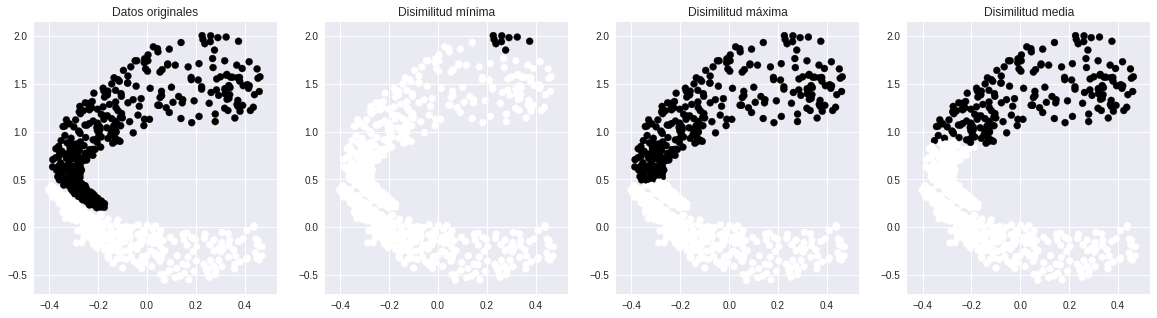

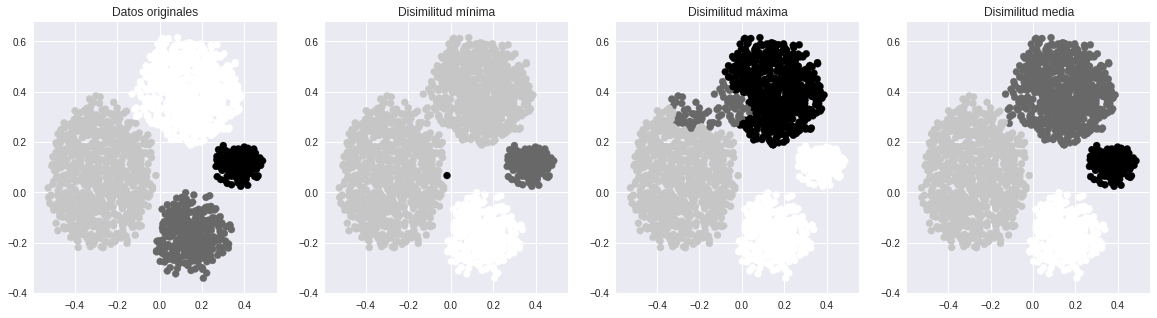

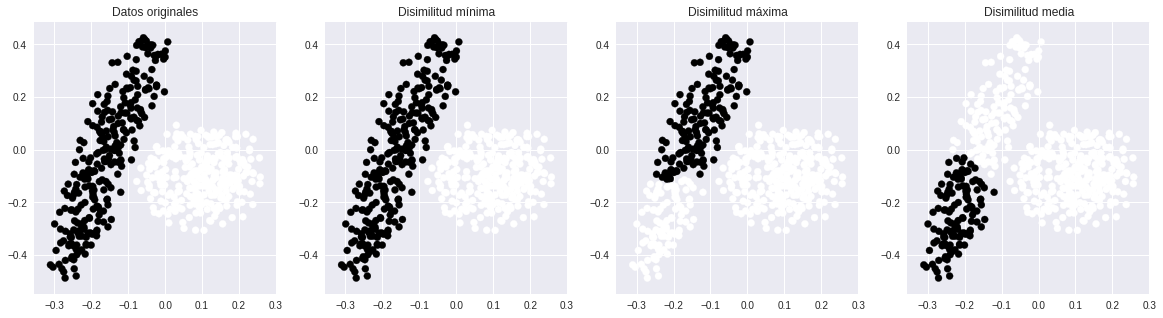

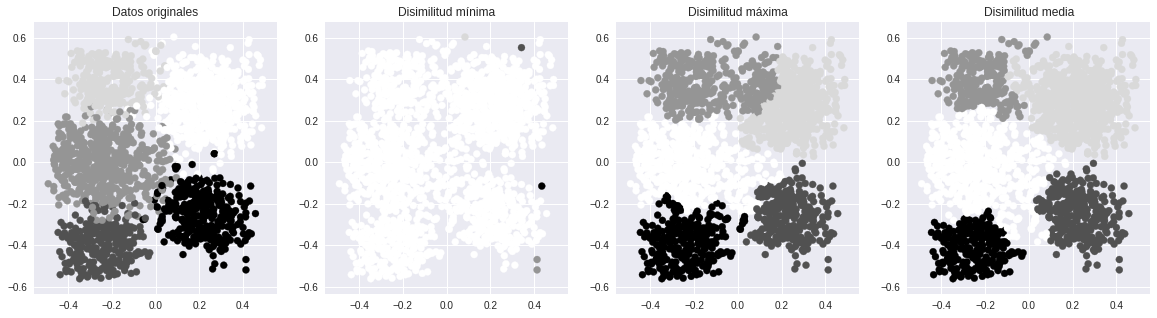

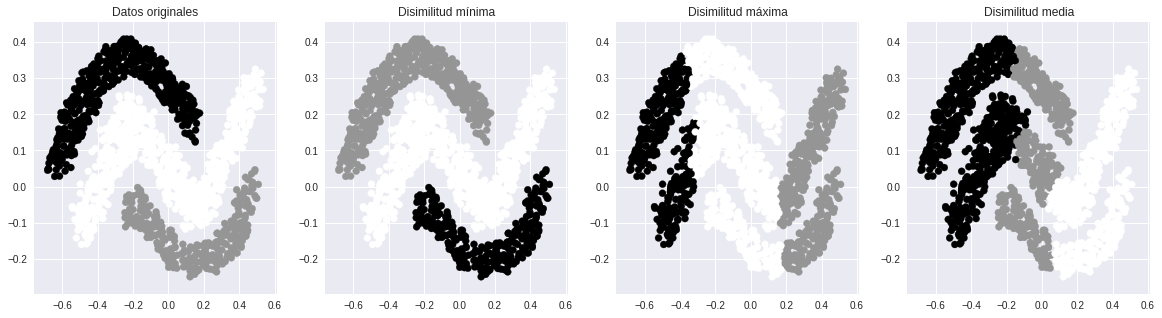

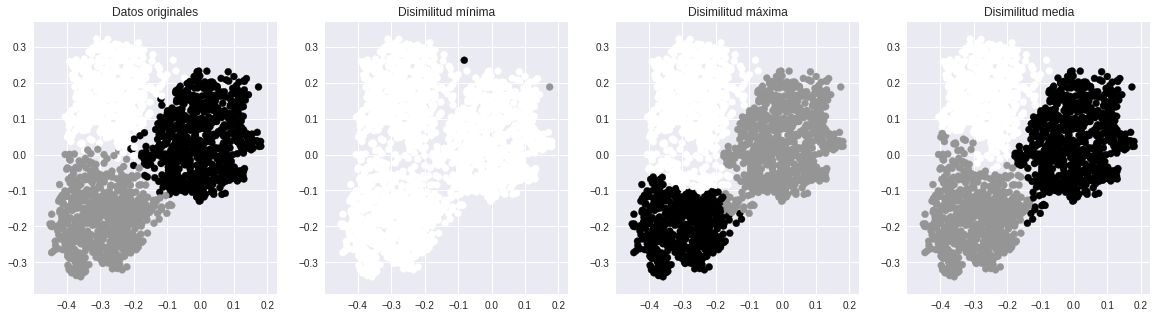

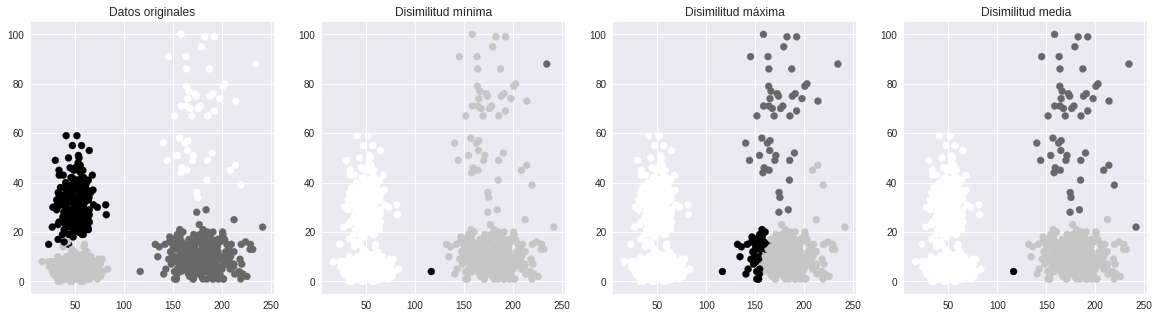

In [43]:
def plot_varios(Dx,Dy,K):
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    ax[0].scatter(Dx[:,0], Dx[:,1], c=Dy)
    ax[0].set_title('Datos originales')

    modelo = linkage(Dx, 'single')
    ax[1].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[1].set_title('Disimilitud mínima')
    
    modelo = linkage(Dx, 'complete')
    ax[2].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[2].set_title('Disimilitud máxima')
    
    modelo = linkage(Dx, 'average')
    ax[3].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[3].set_title('Disimilitud media')


for data_file_url in [
'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_circulos_concentricos.csv',
'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_dos_remolinos.csv',   
'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_diferente_medida.csv',
"https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_dos_guassianas.csv",
"https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_inseparable.csv",
"https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_tres_no_lineales.csv",
"https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_tres_no_separables.csv",
"https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_diferente_densidad.csv"] :
  D = np.array(pd.read_csv(data_file_url,header=0))
  D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
  Dx = D[:,0:2]
  Dy = D[:,2]
  k=len(np.unique(Dy))
  plot_varios(Dx,Dy,k)
  